# Poisson Equation in 2D with Dirichlet Boundary Conditions

We will solve a Poisson equation in 2D:

$$
\triangle u = -2 \pi^2 sin(\pi x)sin(\pi y), \qquad \Omega = [0,1]^2,
$$

with the Dirichlet boundary conditions:

$$
u(x,y) = 0, \qquad (x,y) \in \partial \Omega.
$$

The exact solution is $u(x, y) = sin(\pi x)sin(\pi y)$.

## Implementation and Training

First, we import the libraries:

In [100]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import datetime
import math

We define the $sine$ function and the value of $\pi$.

In [101]:
sin = torch.sin
pi = math.pi

Now, we set the parameters of the neural network: it has a structure with 1 input ($x, y$) and 1 output ($u(x, y)$), 10000 maximum training steps, 2 hidden layers with 32 neurons each, 200 samples and a target minimum loss value of $10^{-3}$.

In [102]:
inputs = 2
outputs = 1
hn_1 = 32
hn_2 = 32
hn_3 = 32
steps = 0
max_steps = 10000
loss = 10
min_loss = 1e-3
log_each = 500
samples = 200
loss_values = []

In [103]:
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

The multilayer perceptron (MLP) structure is:

In [104]:
mlp = nn.Sequential(
    nn.Linear(inputs,hn_1),
    Sine(),
    nn.Linear(hn_1, hn_2),
    Sine(),
    nn.Linear(hn_2, hn_3),
    Sine(),
    nn.Linear(hn_3, outputs)
)

optimizer = torch.optim.Adam(mlp.parameters())
criterion = nn.MSELoss()
mlp.train()

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Sine()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Sine()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Sine()
  (6): Linear(in_features=32, out_features=1, bias=True)
)

In this section, we define a function that calculates the gradients.

In [105]:
def computeGrads(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True, only_inputs=True)
    return grads

Next, we define the main training loop and the timer:

In [106]:
starttime_train = datetime.datetime.now()
print('----Training Started----')

while steps < max_steps and loss > min_loss:
    x = torch.rand(samples)
    y = torch.rand(samples)
    X = torch.stack([x, y], axis=-1)
    X.requires_grad = True
    Y = mlp(X)
    grads = computeGrads(Y, X)
    dudx = grads[:, :1]
    dudy = grads[:, 1:]
    grads2_x = computeGrads(dudx, X)
    d2udx2 = grads2_x[:, :1]
    grads2_y = computeGrads(dudy, X)
    d2udy2 = grads2_y[:, 1:]
    pde_loss = criterion(d2udx2 + d2udy2, (-2 * (pi**2) * sin(pi * x) * sin(pi * y)).unsqueeze(1))

    #boundary condition in x=0, y in [0,1]
    x0 = torch.zeros(samples)
    X_boundary1 = torch.stack([x0, y], axis=-1)
    Y_boundary1 = mlp(X_boundary1)
    zero = torch.zeros(samples, 1)
    bc1_loss = criterion(Y_boundary1, zero)

    #boundary condition in x in [0,1], y=1
    y1 = torch.ones(samples)
    X_boundary2 = torch.stack([x, y1], axis=-1)
    Y_boundary2 = mlp(X_boundary2)
    bc2_loss = criterion(Y_boundary2, zero)

    #boundary condition in x=1, y in [0,1]
    x1 = torch.ones(samples)
    X_boundary3 = torch.stack([x1, y], axis=-1)
    Y_boundary3 = mlp(X_boundary3)
    bc3_loss = criterion(Y_boundary3, zero)
    
    #boundary condition in x in [0,1], y=0
    y0 = torch.zeros(samples)
    X_boundary4 = torch.stack([x, y0], axis=-1)
    Y_boundary4 = mlp(X_boundary4)
    bc4_loss = criterion(Y_boundary4, zero)
    
    bc_loss = bc1_loss + bc2_loss + bc3_loss + bc4_loss

    optimizer.zero_grad()
    loss = pde_loss + 2*bc_loss
    loss.backward()
    optimizer.step()

    loss_values.append(loss.detach().numpy())

    if steps % log_each == 0:
        print(f'Step:{steps}| pde_loss {pde_loss.item():.5f} bc_loss {bc_loss.item():.5f}')

    steps+=1

endtime_train = datetime.datetime.now()
train_time = endtime_train - starttime_train
train_time_formatted = train_time.seconds + train_time.microseconds / 1e6
print('---Training Finished---')

print(f'Training Duration: {steps} steps in {train_time_formatted:.3f} seconds')

----Training Started----
Step:0| pde_loss 84.48676 bc_loss 0.06038
Step:500| pde_loss 0.28757 bc_loss 0.05173
Step:1000| pde_loss 0.11602 bc_loss 0.03768
Step:1500| pde_loss 0.04589 bc_loss 0.02014
Step:2000| pde_loss 0.00696 bc_loss 0.00859
Step:2500| pde_loss 0.00326 bc_loss 0.00350
Step:3000| pde_loss 0.00385 bc_loss 0.00195
Step:3500| pde_loss 0.00197 bc_loss 0.00143
Step:4000| pde_loss 0.00532 bc_loss 0.00086
Step:4500| pde_loss 0.00437 bc_loss 0.00080
Step:5000| pde_loss 0.00160 bc_loss 0.00045
Step:5500| pde_loss 0.00386 bc_loss 0.00037
Step:6000| pde_loss 0.00373 bc_loss 0.00023
---Training Finished---
Training Duration: 6113 steps in 27.447 seconds


## Visualization

To visualize the model and compare results, we plot the output of the trained model, the exact solution and the absolute error: $\text{error}(x,y) = ∣u_{exact}(x,y) - u_{PINN}(x,y)|$.

Text(0.5, 1.0, 'Absolute Error')

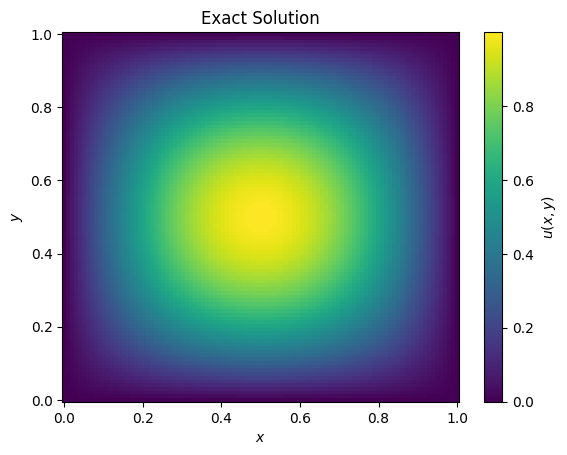

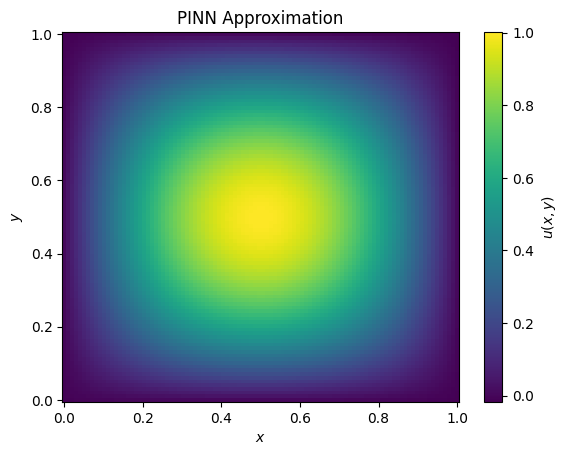

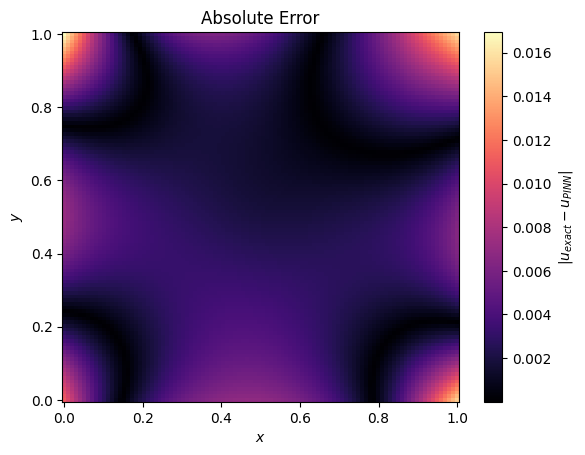

In [110]:
nx = ny = int(samples/2)

x = torch.linspace(0, 1, nx)
y = torch.linspace(0, 1, ny)

X_mesh, Y_mesh = torch.meshgrid(x, y)

def sol(x,y):
    return sin(pi * x) * sin(pi * y)

U = sol(X_mesh, Y_mesh) 

with torch.no_grad():
    X = torch.stack([X_mesh, Y_mesh], axis=-1)
    Y = mlp(X).reshape(ny, nx)

X_mesh = X_mesh.detach().numpy()
Y_mesh = Y_mesh.detach().numpy()
result = Y.detach().numpy()

plt.figure()
pcm = plt.pcolormesh(X_mesh, Y_mesh, U, shading='auto', cmap='viridis')
plt.colorbar(pcm, label=r'$u(x,y)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Exact Solution')

plt.figure()
pcm = plt.pcolormesh(X_mesh, Y_mesh, result, shading='auto', cmap='viridis')
plt.colorbar(pcm, label=r'$u(x,y)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('PINN Approximation')

error = np.abs(U - result)

plt.figure()
pcm = plt.pcolormesh(X_mesh, Y_mesh, error, shading='auto', cmap='magma')
plt.colorbar(pcm, label=r'$|u_{exact} - u_{PINN}|$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Absolute Error')

